CNN LSTM 

Data Set 14
Using data zero data zero padding


In [ ]:
import tensorflow as tf
import datetime
import keras

import numpy as np
import pandas as pd
from keras.models import Sequential, Model, load_model
from keras.layers import Input ,Dense, Dropout, Activation, LSTM, Conv1D
from keras.layers import Lambda, Convolution1D, MaxPooling1D, Flatten, Reshape, BatchNormalization
from keras.layers.wrappers import TimeDistributed
from keras.layers.pooling import GlobalAveragePooling1D
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.metrics import categorical_crossentropy, binary_crossentropy

# In the future may add:
#from spp.SpatialPyramidPooling import SpatialPyramidPooling

#For data saving
import pickle
import random
#other imports
import gzip
import glob
import os
import keras.backend as K
import os
import time 


## Loading the Data for the Model

In [21]:
genome = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']

In [22]:
dense_layer = 1
layer_size = 64 
conv_layer = 2
seq_length = 1000
base_pair = 4
num_strides = 1
pool_size = 4

epochs = 100
batch_size = 200
val_batch_size = 40

##### Model with all the data in one numpy Array

In [16]:
with open('../DataSet15/x_train_allshuffled.npy', 'rb') as f:
    X_train = pickle.load(f)
    print(X_train.shape)
    print(X_train)
with open('../DataSet15/y_train_allshuffled.npy', 'rb') as f:
    Y_train = pickle.load(f)
    print(Y_train.shape)
    print(Y_train)

(67602, 1000, 4)
[[[1 0 0 0]
  [1 0 0 0]
  [1 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[1 0 0 0]
  [1 0 0 0]
  [0 0 0 1]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[1 0 0 0]
  [0 1 0 0]
  [0 1 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 ...

 [[0 0 0 1]
  [0 1 0 0]
  [0 0 0 1]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 1 0]
  [1 0 0 0]
  [0 0 0 1]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[1 0 0 0]
  [0 0 0 1]
  [0 0 0 1]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]]
(67602, 2)
[[0 1]
 [0 1]
 [0 1]
 ...
 [0 1]
 [1 0]
 [1 0]]


In [17]:
# Shuffeling the Data sets before training
shuffler = np.random.permutation(X_train.shape[0])
X_train = X_train[shuffler]
Y_train = Y_train[shuffler]

In [7]:
# The version of Data Set with training and validation pre-split 
'''
with open('../DataSet15/x_train.npy', 'rb') as f:
    X_train = pickle.load(f)
    print(X_train.shape)
with open('../DataSet15/y_train.npy', 'rb') as f:
    Y_train = pickle.load(f)
    print(Y_train.shape)


with open('../DataSet15/x_val.npy', 'rb') as f:
    X_val = pickle.load(f)
    print(X_val.shape)
with open('../DataSet15/y_val.npy', 'rb') as f:
    Y_val = pickle.load(f)
    print(Y_val.shape)
'''

"\nwith open('../DataSet15/x_train.npy', 'rb') as f:\n    X_train = pickle.load(f)\n    print(X_train.shape)\nwith open('../DataSet15/y_train.npy', 'rb') as f:\n    Y_train = pickle.load(f)\n    print(Y_train.shape)\n\n\nwith open('../DataSet15/x_val.npy', 'rb') as f:\n    X_val = pickle.load(f)\n    print(X_val.shape)\nwith open('../DataSet15/y_val.npy', 'rb') as f:\n    Y_val = pickle.load(f)\n    print(Y_val.shape)\n"

In [26]:
# The Neural Network Arcitecture
def train_CNN_full(X_train, Y_train, checkpoint_path, Conv_filter, Conv_layers, Dense_layers, Dense_filter):
    checkpoint_dir = os.path.dirname(checkpoint_path)
    
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True, restore_best_weights=True,
                                                 verbose=1)
    
    earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False)
    ## Model
    model = tf.keras.models.Sequential()             
    model.add(tf.keras.layers.Conv1D(Conv_filter, (4), activation='relu', input_shape=(1000, 4)))
    model.add(tf.keras.layers.MaxPooling1D(4))
    model.add(tf.keras.layers.Dropout(0.1, noise_shape=None, seed=None))
    for l in range(Conv_layers):
        model.add(tf.keras.layers.Conv1D(Conv_filter, (3), activation='relu'))
        model.add(tf.keras.layers.MaxPooling1D(4))
        model.add(tf.keras.layers.Dropout(0.1, noise_shape=None, seed=None))
    model.add(tf.keras.layers.LSTM(64))
    model.add(tf.keras.layers.Flatten())
    for l in range(Dense_layers):
        model.add(tf.keras.layers.Dense(Dense_filter, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.1, noise_shape=None, seed=None))

    model.add(tf.keras.layers.Dense(2, activation='softmax'))      

    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    print(model.summary())

    ## Fitting Model
    history = model.fit(x=X_train, y=Y_train, batch_size=batch_size, epochs=epochs, verbose=2,
                        callbacks=[earlystop, cp_callback], validation_split=0.3, 
                        validation_batch_size=val_batch_size, shuffle=True)

    return history.epoch, model

In [19]:
#Running the Neural Network varying the hyper parameters
checkpoint_path = "../training_1/dataset15_run8_LSTM_64_"
Conv_filter = [32, 64, 128]
Conv_layers = [1, 2, 3]
Dense_layers = [1, 2, 3]
Dense_filter = [32, 64, 128, 256]
history, model = train_CNN_full(X_train, Y_train, checkpoint_path + "_Conv-filter_" + str(Conv_filter[2])+ "Conv_layers_" + str(Conv_layers[0]) +"Dense_layers_" + str(Dense_layers[2]) + "Dense_filter_" + str(Dense_filter[2]), Conv_filter[2], Conv_layers[0], Dense_layers[2], Dense_filter[2])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 997, 128)          2176      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 249, 128)          0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 249, 128)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 247, 128)          49280     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 61, 128)           0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 61, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)               

In [61]:
# Running with the Neural Network with a second set of hyper parameters 
checkpoint_path = "../training_2/dataset15_run8_LSTM_64_"
Conv_filter = [32, 64, 128]
Conv_layers = [1, 2, 3]
Dense_layers = [1, 2, 3]
Dense_filter = [32, 64, 128, 256]
for i in Conv_filter:
    history, model = train_CNN_full(X_train, Y_train, checkpoint_path + "_Conv-filter_" + str(i)+ "Conv_layers_" + str(Conv_layers[1])
                                    +"Dense_layers_" + str(Dense_layers[1]) + "Dense_filter_" + str(Dense_filter[1]), i, Conv_layers[1], Dense_layers[1], Dense_filter[1])
for i in Conv_layers:
    history, model = train_CNN_full(X_train, Y_train, checkpoint_path + "_Conv-filter_" + str(Conv_filter[1])+ "Conv_layers_" + str(i)
                                    +"Dense_layers_" + str(Dense_layers[1]) + "Dense_filter_" + str(Dense_filter[1]), Conv_filter[1], i, Dense_layers[1], Dense_filter[1])
for i in Dense_layers:
    history, model = train_CNN_full(X_train, Y_train, checkpoint_path + "_Conv-filter_" + str(Conv_filter[1])+ "Conv_layers_" + str(Conv_layers[1])
                                    +"Dense_layers_" + str(i) + "Dense_filter_" + str(Dense_filter[1]), Conv_filter[1], Conv_layers[1], i, Dense_filter[1])
for i in Dense_filter:
    history, model = train_CNN_full(X_train, Y_train, checkpoint_path + "_Conv-filter_" + str(Conv_filter[1])+ "Conv_layers_" + str(Conv_layers[1])
                                    +"Dense_layers_" + str(Dense_layers[1]) + "Dense_filter_" + str(i), Conv_filter[1], Conv_layers[1], Dense_layers[1], i)

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_81 (Conv1D)           (None, 997, 32)           544       
_________________________________________________________________
max_pooling1d_81 (MaxPooling (None, 249, 32)           0         
_________________________________________________________________
dropout_135 (Dropout)        (None, 249, 32)           0         
_________________________________________________________________
conv1d_82 (Conv1D)           (None, 247, 32)           3104      
_________________________________________________________________
max_pooling1d_82 (MaxPooling (None, 61, 32)            0         
_________________________________________________________________
dropout_136 (Dropout)        (None, 61, 32)            0         
_________________________________________________________________
conv1d_83 (Conv1D)           (None, 59, 32)          

KeyboardInterrupt: 

In [31]:
# Varying the size of the LSTM layer Only
checkpoint_path = "../training_1/dataset15_run5_LSTM-"
LSTM_array = [64, 128, 256, 512, 1024]
for i in LSTM_array:
    history, model = train_CNN_full(X_train, Y_train, checkpoint_path + str(i + "_ckpy_", i)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 997, 64)           1088      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 249, 64)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 249, 64)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 247, 64)           12352     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 61, 64)            0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 61, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)               

KeyboardInterrupt: 

### Testing which model to pick before running the testing data

In [3]:
with open('../DataSet15/x_train_allshuffled.npy', 'rb') as f:
    X_train = pickle.load(f)
    print(X_train.shape)
    print(X_train)
with open('../DataSet15/y_train_allshuffled.npy', 'rb') as f:
    Y_train = pickle.load(f)
    print(Y_train.shape)
    print(Y_train)

(67602, 1000, 4)
[[[1 0 0 0]
  [1 0 0 0]
  [1 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[1 0 0 0]
  [1 0 0 0]
  [0 0 0 1]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[1 0 0 0]
  [0 1 0 0]
  [0 1 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 ...

 [[0 0 0 1]
  [0 1 0 0]
  [0 0 0 1]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 1 0]
  [1 0 0 0]
  [0 0 0 1]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[1 0 0 0]
  [0 0 0 1]
  [0 0 0 1]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]]
(67602, 2)
[[0 1]
 [0 1]
 [0 1]
 ...
 [0 1]
 [1 0]
 [1 0]]


In [4]:
shuffler = np.random.permutation(X_train.shape[0])
X_train = X_train[shuffler]
Y_train = Y_train[shuffler]

In [5]:
def split_two_arrays(x_array_1, y_array_1, length, sequence_length, num_categories):
    num_train = 20280
    print(num_train)
    Y_train = np.zeros((length, num_categories), dtype=np.int8)
    X_train = np.zeros((length, sequence_length, 4), dtype=np.int8)
    for i in range(0, 20280):
        X_train[i, :, :] = x_array_1[i]
        Y_train[i, :] = y_array_1[i] 
    # minues 2 instead of one because the last value in the testing array is null for some reason so I am getting rid of it
    return X_train, Y_train

In [6]:
X_val, Y_val = split_two_arrays(X_train, Y_train, 20280, 1000, 2)
print(X_val.shape)
print(Y_val.shape)
print(X_val)
print(Y_val)

20280
(20280, 1000, 4)
(20280, 2)
[[[0 0 0 1]
  [0 0 1 0]
  [1 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[1 0 0 0]
  [0 0 0 1]
  [0 1 0 0]
  ...
  [1 0 0 0]
  [0 0 0 1]
  [1 0 0 0]]

 [[0 1 0 0]
  [0 1 0 0]
  [0 1 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 ...

 [[0 1 0 0]
  [0 0 1 0]
  [1 0 0 0]
  ...
  [0 0 0 1]
  [0 0 0 1]
  [1 0 0 0]]

 [[1 0 0 0]
  [0 0 1 0]
  [0 1 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 1 0]
  [0 0 0 1]
  [0 0 1 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]]
[[0 1]
 [1 0]
 [1 0]
 ...
 [0 1]
 [1 0]
 [0 1]]


In [7]:
# Used if needed the Model Architecure when loading saved models 
def create_model(X_train, Y_train, checkpoint_path, Conv_filter, Conv_layers, Dense_layers, Dense_filter):
    ## Callbacks
    '''
    class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if(logs.get('loss')>0.99):
                print("\nReached 99% accuracy so cancelling training!")
                self.model.stop_training = True
    callback = myCallback()
    '''
    
    checkpoint_dir = os.path.dirname(checkpoint_path)
    
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True, restore_best_weights=True,
                                                 verbose=1)
    
    earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False)

    
    ## Model
    model = tf.keras.models.Sequential()             
    model.add(tf.keras.layers.Conv1D(Conv_filter, (4), activation='relu', input_shape=(1000, 4)))
    model.add(tf.keras.layers.MaxPooling1D(4))
    model.add(tf.keras.layers.Dropout(0.1, noise_shape=None, seed=None))
    for l in range(Conv_layers):
        model.add(tf.keras.layers.Conv1D(Conv_filter, (3), activation='relu'))
        model.add(tf.keras.layers.MaxPooling1D(4))
        model.add(tf.keras.layers.Dropout(0.1, noise_shape=None, seed=None))
    #model.add(tf.keras.layers.LSTM(64))
    model.add(tf.keras.layers.Flatten())
    for l in range(Dense_layers):
        model.add(tf.keras.layers.Dense(Dense_filter, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.1, noise_shape=None, seed=None))

    model.add(tf.keras.layers.Dense(2, activation='softmax'))      

    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    ## Fitting Model
    #history = model.fit(x=X_train, y=Y_train, batch_size=batch_size, epochs=epochs, verbose=2,
    #                    callbacks=[earlystop, cp_callback], validation_split=0.3, 
    #                    validation_batch_size=val_batch_size, shuffle=True)

    return model


In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Going through all of the tested model variations and comparing validation loss and accuracy

checkpoint_path = "../training_1/dataset15_run7_LSTM_64_"
Conv_filter = [32, 64, 128]
Conv_layers = [1, 2, 3]
Dense_layers = [1, 2, 3]
Dense_filter = [32, 64, 128, 256]
for i in Conv_filter:
    print("Conv_filer: " + str(i))
    #latest = tf.train.latest_checkpoint(checkpoint_path + "_Conv-filter_" + str(i)+ "Conv_layers_" + str(Conv_layers[1])
    #                                +"Dense_layers_" + str(Dense_layers[1]) + "Dense_filter_" + str(Dense_filter[1]))
    #print(latest)
    # Create a new model instance
    model = create_model(X_val, Y_val, checkpoint_path + "_Conv-filter_" + str(i)+ "Conv_layers_" + str(Conv_layers[1])
                                    +"Dense_layers_" + str(Dense_layers[1]) + "Dense_filter_" + str(Dense_filter[1]), i, Conv_layers[1], Dense_layers[1], Dense_filter[1])
    # 1Load the previously saved weights
   # model.load_weights(latest)
    model.load_weights(checkpoint_path + "_Conv-filter_" + str(i)+ "Conv_layers_" + str(Conv_layers[1])
                                    +"Dense_layers_" + str(Dense_layers[1]) + "Dense_filter_" + str(Dense_filter[1]))
    # Re-evaluate the model
    loss, acc = model.evaluate(X_val,  Y_val, verbose=2)
    print("Restored model, accuracy: {:5.2f}%".format(100*acc))
     
    predicted = (model.predict_classes(X_val))
    
    expected = []
 
    for label in Y_val:
        expected.append(label[1])
    print(expected[0])
    print(len(expected))

    results = confusion_matrix(expected, predicted)
    print(results)

for i in Conv_layers:
    print("Conv_layer: " + str(i))
    #latest = tf.train.latest_checkpoint(checkpoint_path + "_Conv-filter_" + str(Conv_filter[1])+ "Conv_layers_" + str(i)
    #                                +"Dense_layers_" + str(Dense_layers[1]) + "Dense_filter_" + str(Dense_filter[1])+".data-00000-of-00001")
    #print(latest)
    # Create a new model instance
    model = create_model(X_val, Y_val, checkpoint_path + "_Conv-filter_" + str(Conv_filter[1])+ "Conv_layers_" + str(i)
                                        +"Dense_layers_" + str(Dense_layers[1]) + "Dense_filter_" + str(Dense_filter[1]), Conv_filter[1], i, Dense_layers[1], Dense_filter[1])
    # 2Load the previously saved weights
    model.load_weights(checkpoint_path + "_Conv-filter_" + str(Conv_filter[1])+ "Conv_layers_" + str(i)
                                    +"Dense_layers_" + str(Dense_layers[1]) + "Dense_filter_" + str(Dense_filter[1]))

    # Re-evaluate the model
    loss, acc = model.evaluate(X_val,  Y_val, verbose=2)
    print("Restored model, accuracy: {:5.2f}%".format(100*acc))
    
    predicted = (model.predict_classes(X_val))
    
    expected = []
 
    for label in Y_val:
        expected.append(label[1])
    print(expected[0])
    print(len(expected))

    results = confusion_matrix(expected, predicted)
    print(results)

for i in Dense_layers:
    print("Dense_layers: " + str(i))
    #latest = tf.train.latest_checkpoint(checkpoint_path + "_Conv-filter_" + str(Conv_filter[1])+ "Conv_layers_" + str(Conv_layers[1])
    #                                +"Dense_layers_" + str(i) + "Dense_filter_" + str(Dense_filter[1])+".data-00000-of-00001")
    #print(latest)
    # Create a new model instance
    model = create_model(X_val, Y_val, checkpoint_path + "_Conv-filter_" + str(Conv_filter[1])+ "Conv_layers_" + str(Conv_layers[1])
                                    +"Dense_layers_" + str(i) + "Dense_filter_" + str(Dense_filter[1]), Conv_filter[1], Conv_layers[1], i, Dense_filter[1])

    # 3Load the previously saved weights
    model.load_weights(checkpoint_path + "_Conv-filter_" + str(Conv_filter[1])+ "Conv_layers_" + str(Conv_layers[1])
                                    +"Dense_layers_" + str(i) + "Dense_filter_" + str(Dense_filter[1]))

    # Re-evaluate the model
    loss, acc = model.evaluate(X_val,  Y_val, verbose=2)
    print("Restored model, accuracy: {:5.2f}%".format(100*acc))
    #history,
    predicted = (model.predict_classes(X_val))
    
    expected = []
 
    for label in Y_val:
        expected.append(label[1])
    print(expected[0])
    print(len(expected))

    results = confusion_matrix(expected, predicted)
    print(results)

for i in Dense_filter:
    print("Dense_filter: " + str(i))
    #latest = tf.train.latest_checkpoint(checkpoint_path + "_Conv-filter_" + str(Conv_filter[1])+ "Conv_layers_" + str(Conv_layers[1])
    #                                +"Dense_layers_" + str(Dense_layers[1]) + "Dense_filter_" + str(i)+".data-00000-of-00001")
    #print(latest)
    # Create a new model instance
    model = create_model(X_val, Y_val, checkpoint_path + "_Conv-filter_" + str(Conv_filter[1])+ "Conv_layers_" + str(Conv_layers[1])
                                    +"Dense_layers_" + str(Dense_layers[1]) + "Dense_filter_" + str(i), Conv_filter[1], Conv_layers[1], Dense_layers[1], i)

    # 4Load the previously saved weights
    model.load_weights(checkpoint_path + "_Conv-filter_" + str(Conv_filter[1])+ "Conv_layers_" + str(Conv_layers[1])
                                    +"Dense_layers_" + str(Dense_layers[1]) + "Dense_filter_" + str(i))

    # Re-evaluate the model
    loss, acc = model.evaluate(X_val,  Y_val, verbose=2)
    print("Restored model, accuracy: {:5.2f}%".format(100*acc))
    #history, 
    predicted = (model.predict_classes(X_val))
    
    expected = []
 
    for label in Y_val:
        expected.append(label[1])
    print(expected[0])
    print(len(expected))

    results = confusion_matrix(expected, predicted)
    print(results)


Conv_filer: 32
634/634 - 5s - loss: 0.4346 - accuracy: 0.7957
Restored model, accuracy: 79.57%
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
1
20280
[[8120 1301]
 [2843 8016]]
Conv_filer: 64
634/634 - 9s - loss: 0.3866 - accuracy: 0.8300
Restored model, accuracy: 83.00%
1
20280
[[8401 1020]
 [2428 8431]]
Conv_filer: 128
634/634 - 16s - loss: 0.3015 - accuracy: 0.8851
Restored model, accuracy: 88.51%
1
20280
[[8411 1010]
 [1321 9538]]
Conv_layer: 1
634/634 - 8s - loss: 0.3250 - accuracy: 0.8767
Restored model, accuracy: 87.67%
1
20280
[[7983 1438]
 [1063 9796]]
Conv_layer: 2
634/634 - 8s - loss: 0.3866 - accuracy: 0.8300
Restored model, accuracy: 83.00%
1
20280
[[8401 1020]
 [2428 8431]]
Conv_layer: 3
63

In [ ]:
#Loading the models one by one if needed

In [ ]:
with open('../partition_train_val_a.dat', 'rb') as f:
    partition = pickle.load(f)
train_samples_IDs = partition['train']
val_samples_IDs = partition['validation']
IDs = partition['labels']

In [ ]:
predicted = []
Y_val_expected = []
count_input_val = 0
num_val_seq = len(val_samples)
done = False
while count_input_val < num_val_seq and not(done):
    X_val = np.zeros((1, 1000, 4), dtype=np.int8)
    if count_input_val < (num_val_seq - 1):
        for i in range(0, 1):
            a = val_samples[count_input_val]
            X_val[i, :, :] = np.load('../model_11_data_4/' + val_samples[count_input_val] + '.npy') 
            count_input_val += 1
        predict = (model.predict_classes(X_val))
        for label in predict:
            predicted.append(label)
    else:
        done = True
    if count_input_val == 16200:
        done = True
    print(count_input_val)
print(len(predicted))
print(predicted[0])

In [ ]:
expected = []

for label in val_samples:
    expected.append(labels[label][0][0])
print(expected[0])
print(len(expected))


In [ ]:
# Confusion matrix for data visualizaiton
from sklearn.metrics import confusion_matrix
 
results = confusion_matrix(expected[0:13400], predicted)
print(results)
# Printing the precision and recall, among other metrics
#print(metrics.classification_report(y_act, y_pred, labels=["a", 
#"b"]))

In [ ]:
import seaborn as sns
# Heat map for data visulaizaiton
sns.heatmap(results/np.sum(results), annot=True, 
            fmt='.2%', cmap='Blues')
print(model.summary)

## Loading Data for Final Model Testing

In [29]:
with open('../DataSet15/x_test_allshuffled.npy', 'rb') as f:
    X_test = pickle.load(f)
    print(X_test.shape)
    print(X_test)
with open('../DataSet15/y_test_allshuffled.npy', 'rb') as f:
    Y_test = pickle.load(f)
    print(Y_test.shape)
    print(Y_test)

(16382, 1000, 4)
[[[0 0 1 0]
  [0 0 0 1]
  [0 0 1 0]
  ...
  [0 0 0 1]
  [1 0 0 0]
  [0 0 1 0]]

 [[0 1 0 0]
  [0 1 0 0]
  [1 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 1 0]
  [0 1 0 0]
  [0 0 1 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 ...

 [[0 0 0 1]
  [0 1 0 0]
  [0 0 0 1]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 1 0 0]
  [0 0 1 0]
  [1 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 1 0 0]
  [0 0 0 1]
  [0 1 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]]
(16382, 2)
[[1 0]
 [0 1]
 [0 1]
 ...
 [0 1]
 [1 0]
 [1 0]]


# Final Model created after picking best hyper parameters

In [30]:
def create_model_final(X_train, Y_train, checkpoint_path, Conv_filter, Conv_layers, Dense_layers, Dense_filter):
    ## Callbacks
    '''
    class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if(logs.get('loss')>0.99):
                print("\nReached 99% accuracy so cancelling training!")
                self.model.stop_training = True
    callback = myCallback()
    '''
    
    checkpoint_dir = os.path.dirname(checkpoint_path)
    
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True, restore_best_weights=True,
                                                 verbose=1)
    
    earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False)

    
    ## Model
    model = tf.keras.models.Sequential()             
    model.add(tf.keras.layers.Conv1D(Conv_filter, (4), activation='relu', input_shape=(1000, 4)))
    model.add(tf.keras.layers.MaxPooling1D(4))
    model.add(tf.keras.layers.Dropout(0.1, noise_shape=None, seed=None))
    for l in range(Conv_layers):
        model.add(tf.keras.layers.Conv1D(Conv_filter, (3), activation='relu'))
        model.add(tf.keras.layers.MaxPooling1D(4))
        model.add(tf.keras.layers.Dropout(0.1, noise_shape=None, seed=None))
    model.add(tf.keras.layers.LSTM(64))
    model.add(tf.keras.layers.Flatten())
    for l in range(Dense_layers):
        model.add(tf.keras.layers.Dense(Dense_filter, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.1, noise_shape=None, seed=None))

    model.add(tf.keras.layers.Dense(2, activation='softmax'))      

    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    ## Fitting Model
    #history = model.fit(x=X_train, y=Y_train, batch_size=batch_size, epochs=epochs, verbose=2,
    #                    callbacks=[earlystop, cp_callback], validation_split=0.3, 
    #                    validation_batch_size=val_batch_size, shuffle=True)

    return model


### Testing the final model on the Testing Data Set

In [32]:

from sklearn.metrics import confusion_matrix
import seaborn as sns

model.load_weights(checkpoint_path)
# Re-evaluate the model
loss, acc = model.evaluate(X_test,  Y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

predicted = (model.predict_classes(X_test))

expected = []

for label in Y_test:
    expected.append(label[1])
print(expected[0])
print(len(expected))

results = confusion_matrix(expected, predicted)
print(results)

512/512 - 10s - loss: 0.4552 - accuracy: 0.7934
Restored model, accuracy: 79.34%
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
0
16382
[[6061 1656]
 [1728 6937]]


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 997, 128)          2176      
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 249, 128)          0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 249, 128)          0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 247, 128)          49280     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 61, 128)           0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 61, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)               

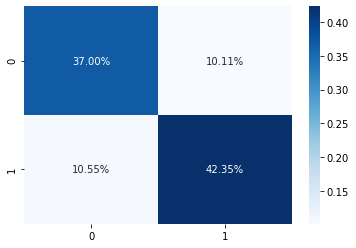

In [33]:
# Final Confusion Matrix
sns.heatmap(results/np.sum(results), annot=True, 
            fmt='.2%', cmap='Blues')
print(model.summary())